# Lab 6: Rasters and Normalized Difference Indices

## Objectives:
- **Understand multiband raster data:** Learn what multiband rasters are and how Sentinel‑2 imagery is organized.
- **Compute Normalized Difference Vegetation Index (NDVI):**

  $NDVI = \frac{NIR - Red}{NIR + Red}$

- **Compute Normalized Difference Snow Index (NDSI):**

  $NDSI = \frac{Green - SWIR1}{Green + SWIR1}$

- **Visualize results:** Plot the original true-color composite and the computed indices.
- **Analyze NDIs:** For example, calculate area of vegetation or snow.
- **Export outputs:** Save the computed indices as GeoTIFFs for further analysis.

### Why are NDIs useful?
- **NDVI:** Provides an estimate of vegetation health and biomass.
- **NDSI:** Helps detect snow cover and differentiate between snow and clouds or bare soil.


## Overview of Sentinel-2 bands:

| Sentinel-2 Bands              | Central Wavelength (µm) | Resolution (m)^ |
|-------------------------------|-------------------------|----------------|
| Band 1 - Coastal aerosol      | 0.443                  | 60             |
| Band 2 - Blue                 | 0.490                  | 10             |
| Band 3 - Green                | 0.560                  | 10             |
| Band 4 - Red                  | 0.665                  | 10             |
| Band 5 - Vegetation Red Edge  | 0.705                  | 20             |
| Band 6 - Vegetation Red Edge  | 0.740                  | 20             |
| Band 7 - Vegetation Red Edge  | 0.783                  | 20             |
| Band 8 - NIR                  | 0.842                  | 10             |
| Band 8A - Vegetation Red Edge | 0.865                  | 20             |
| Band 9 - Water vapour         | 0.945                  | 60             |
| Band 10 - SWIR - Cirrus       | 1.375                  | 60             |
| Band 11 - SWIR                | 1.610                  | 20             |
| Band 12 - SWIR                | 2.190                  | 20             |

*^Note: All bands have been resampled to 50 m spatial resolution for this lab.*
<br>NIR = Near Infrared
<br>SWIR = Shortwave Infrared

In [1]:
# Preamble
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Tip: Always import your libraries at the top of your script/notebook

## Reading the data

In [2]:
raster_path = 'Sentinel2_sheet5.tif'

# Open the mosaic raster (exported from Google Earth Engine at 50 m resolution)
with rio.open(raster_path) as src:
    # We use src.meta.copy() to copy all the spatial and format-related metadata from the input raster to a variable.
    # This is helpful when exporting a new raster later on.
    meta = src.meta.copy()

    # Assign each band using src.read()
    # Note: Rasterio uses 1-indexed band numbers when reading from a file (e.g., src.read(4) for band 4)
    blue   = src.read(2)
    green  = src.read(3)
    red    = src.read(4)
    nir    = src.read(8)
    swir   = src.read(11)

    # Get UTM spatial bounds (for plotting)
    left, bottom, right, top = src.bounds
    extent = [left, right, bottom, top]

**Exercise 1:** Look at the metadata of the raster to answer the following:
1. What is the CRS of the image?
2. How many dimensions are contained in this image? What is each dimension?
3. What is the data type?

### Visualizing a single band

Below, we visualize the raw SWIR band.

991.5 11948.5


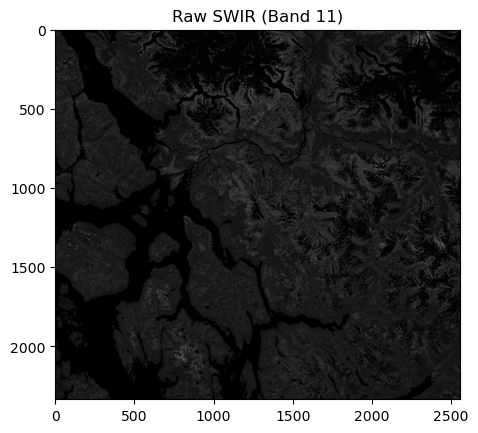

In [3]:
plt.imshow(swir, cmap='gray')
plt.title("Raw SWIR (Band 11)")

print(swir.min(), swir.max())

It seems pretty dark. By default, imshow only displays floats between 0 and 1 or integers between 0 and 255.

We can use a stretching function to rescale our data for display.

In [4]:
# Define stretch function for display purposes
def stretch(array, min = 2.0, max = 98.0):
    """
    Stretch an array to the range 0-1 based on given percentile values.
    This is for display only and should not be used for index calculations.
    """
    # Compute the lower and upper percentiles for stretching.
    lower = np.percentile(array, min)
    upper = np.percentile(array, max)
    # Clip the values to remove extreme outliers
    clipped = np.clip(array, lower, upper)
    # Stretch the values to ensure they stay within the range [0, 1] for visualization
    stretched = (clipped - lower) / (upper - lower)
    return stretched

**Important note:** We apply the stretch function on the composite solely for visualization. For the index calculations, *always* use the raw (or correctly scaled) radiometric values.

0.0 1.0


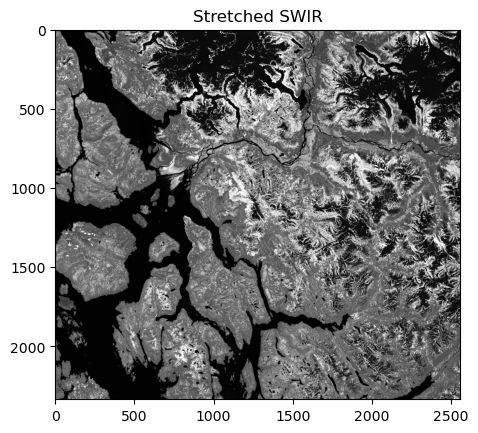

In [5]:
# Stretch and display SWIR
plt.imshow(stretch(swir), cmap='gray')
plt.title("Stretched SWIR")

print(stretch(swir).min(), stretch(swir).max())

**Exercise 2:** Plot two histograms of each the raw and stretched SWIR band. How does changing the percentile range affect the visualization? Explain in one to two sentences.

Extremely low or high values (below the 2nd percentile or above the 98th) are forced to the min or max of the display scale. This prevents a few extreme pixels from dominating the color/brightness range.

### True Colour Composite

For a true colour composite we combine the Red, Green, and Blue bands.

We use `np.dstack` to stack the 2D arrays into a single 3D array along the third (colour) axis.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2334, 2559, 3)


Text(0.5, 1.0, 'True Colour Image (RGB)')

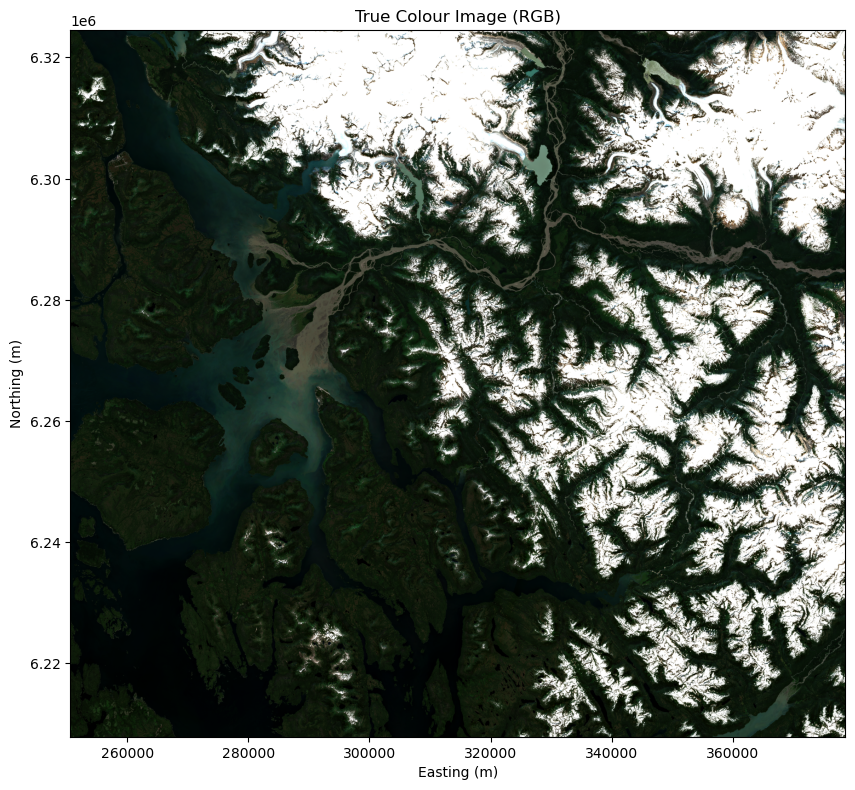

In [6]:
true_colour = np.dstack((red, green, blue))
true_colour = stretch(true_colour)
print(true_colour.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(true_colour * 2.5, extent=extent) # Multiply by 2.5 to brighten the image
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("True Colour Image (RGB)")

**Exercise 3:** Create a false colour composite by playing around with different band combinations. Adjust your plot title accordingly.

## Index calculations

### NDVI

In [7]:
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) # Clip NDVI to the expected range (-1, 1)
print(ndvi.shape) # Note: 1-dimensional array

(2334, 2559)


Clipping ensures that any outlier arithmetic (due to division by very small sums) does not produce values outside the theoretical range of -1 to 1. Often the computed NDVI will naturally fall within this range, but clipping is a good safety measure for visualization.

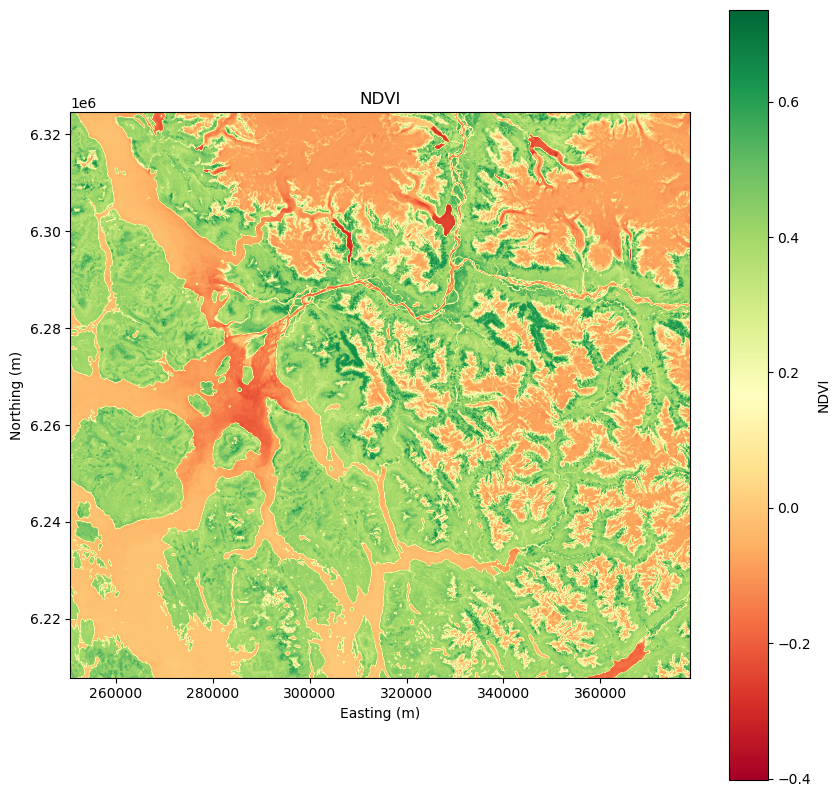

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ndvi_im = ax.imshow(ndvi, extent=extent, cmap='RdYlGn')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("NDVI")
fig.colorbar(ndvi_im, ax=ax, label='NDVI')

### NDSI

In [9]:
ndsi = (green - swir) / (green + swir)
ndsi = np.clip(ndsi, -1, 1)

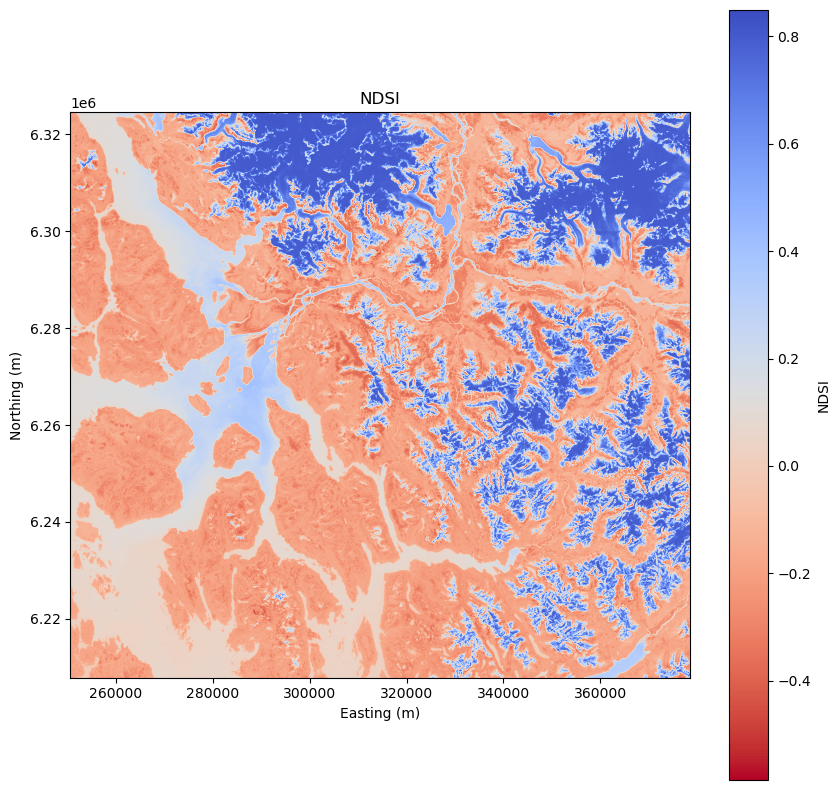

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ndsi_im = ax.imshow(ndsi, extent=extent, cmap='coolwarm_r')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("NDSI")
fig.colorbar(ndsi_im, ax=ax, label='NDSI')

### Saving results as GeoTIFFs

At some point you may want to export your NDI rasters for use in GIS software. The following provides an option to do that while retaining proper metadata:

In [11]:
meta.update({
    "count": 1,
})

# Export NDVI as a GeoTIFF
with rio.open("NDVI_output.tif", "w", **meta) as dst:
    dst.write(ndvi, 1)

# Export NDSI as a GeoTIFF
with rio.open("NDSI_output.tif", "w", **meta) as dst:
    dst.write(ndsi, 1)

Code breakdown:

- We set metadata to `"count": 1` because our NDVI or NDSI output is a single-band raster, even if the source is multiband.

- Using `rio.open()` in write mode (`"w"`) along with the updated metadata, we then write the array to the first band of the new file using `dst.write(ndvi, 1)`. The same procedure applies to NDSI.

- `**meta` unpacks the dictionary meta and passes its contents as keyword arguments to `rio.open()`.

## Binary Mapping Indices

Using histograms to examine the distribution of index values helps you choose appropriate thresholds.

The code flattens the NDVI and NDSI arrays (turning them into 1D arrays) using `array.flatten()` and creates histograms with 50 bins. A red dashed vertical line is drawn at the threshold value to help you visualize the cutoff.

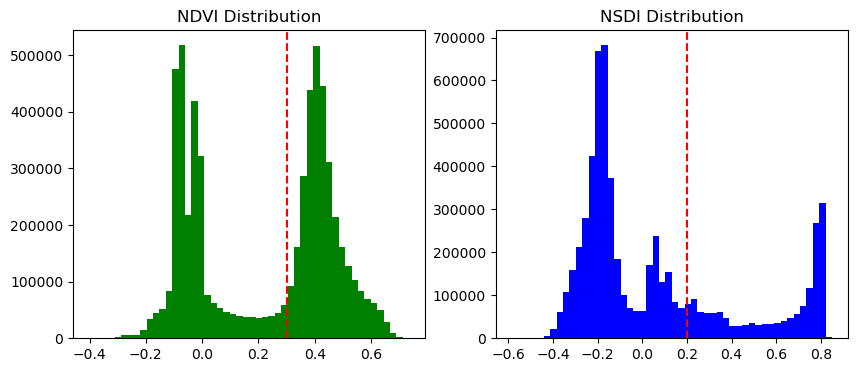

In [12]:
# Define thresholds for classification
ndvi_threshold = 0.3
ndsi_threshold = 0.2

plt.figure(figsize=(10, 4))

# NDVI
plt.subplot(121)
plt.hist(ndvi.flatten(), bins=50, color='green')
plt.axvline(ndvi_threshold, color='red', linestyle='dashed')
plt.title('NDVI Distribution')

# NDSI
plt.subplot(122)
plt.hist(ndsi.flatten(), bins=50, color='blue')
plt.axvline(ndsi_threshold, color='red', linestyle='dashed')
plt.title('NSDI Distribution')
plt.show()

By converting the Boolean array (result of `ndvi > ndvi_threshold`) to an integer array using the function `.astype(int)`, we get a clean binary map where pixels meeting the condition are 1 and all others are 0.

In [13]:
# Create binary classification maps
ndvi_binary = (ndvi > ndvi_threshold).astype(int)  # 1 for vegetation, 0 for no vegetation
ndsi_binary = (ndsi > ndsi_threshold).astype(int)  # 1 for snow, 0 for no snow

`ListedColormap` is a submodule of `Matplotlib` that allows us to create a custom colormap where the first color corresponds to 0 and the second color to 1. 

Here, `'none'` means that 0 values (i.e., non-vegetation or non-snow areas) will appear transparent.

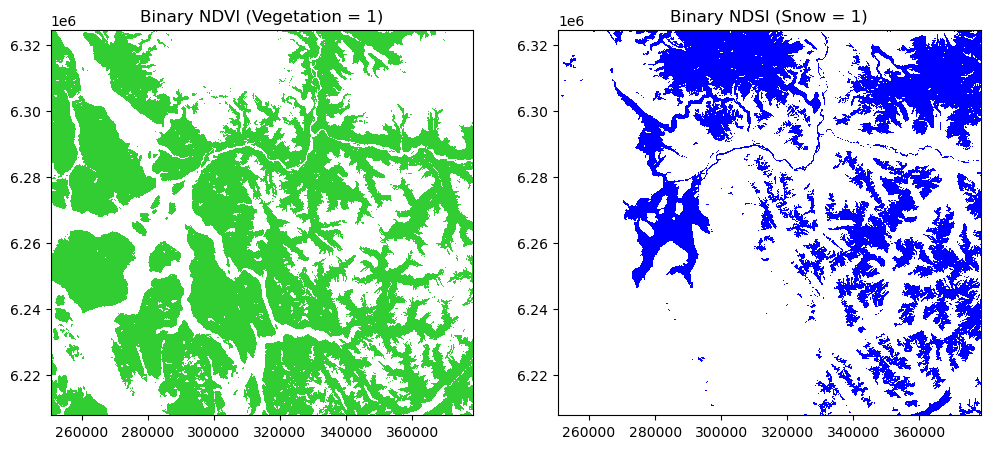

In [14]:
# Define custom colormaps
ndvi_cmap = ListedColormap(['none', 'limegreen'])
ndsi_cmap = ListedColormap(['none', 'blue'])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title("Binary NDVI (Vegetation = 1)")
ax[0].imshow(ndvi_binary, extent=extent, cmap=ndvi_cmap)

ax[1].set_title("Binary NDSI (Snow = 1)")
ax[1].imshow(ndsi_binary, extent=extent, cmap=ndsi_cmap)

In each subplot, the true color composite is plotted as the base layer. Then the binary mask is overlaid with transparency `alpha()`, so that you can see the underlying true color image where there is no classification.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


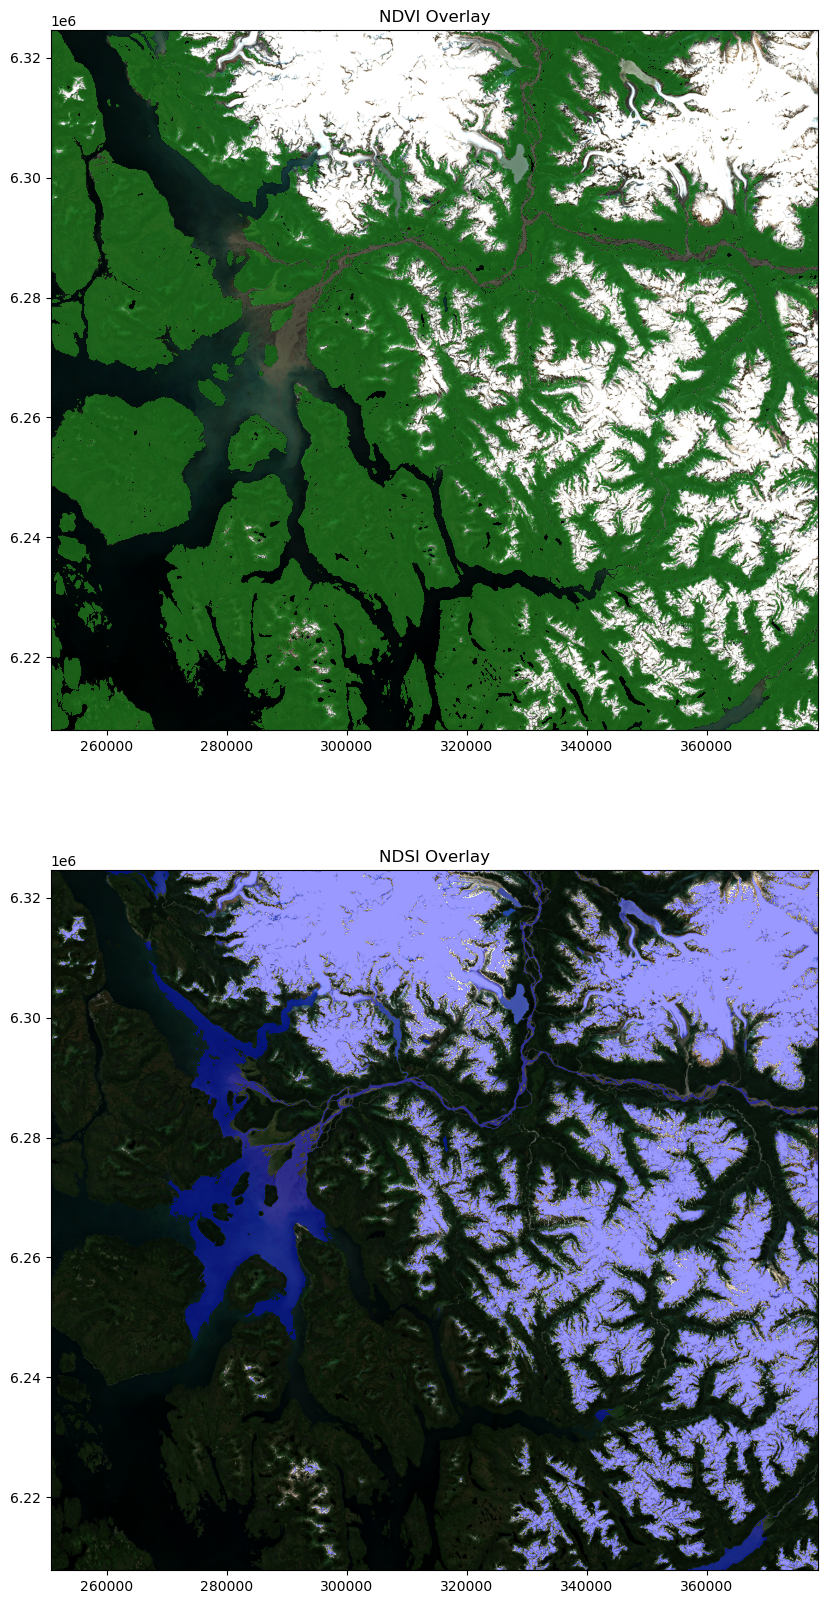

In [15]:
# Plot overlays
fig, ax = plt.subplots(2, 1, figsize=(10, 20))

# True color background
ax[0].imshow(true_colour * 2.5, extent=extent)
ax[0].set_title("NDVI Overlay")

ax[1].imshow(true_colour * 2.5, extent=extent)
ax[1].set_title("NDSI Overlay")

# Overlay binary maps
ax[0].imshow(ndvi_binary, extent=extent, cmap=ndvi_cmap, alpha=0.4)
ax[1].imshow(ndsi_binary, extent=extent, cmap=ndsi_cmap, alpha=0.4)

**Exercise 4:** As seen above, a lot of water was misidentified as snow using the NDSI. Change the NDSI threshold to more accurately capture snow in this image. 

Plot your updated threshold as a binary overlay on the false colour image you created in Exercise 3.

### Extracting Areas from Binary Classified Raster Maps

Once we have created our binary classification maps we can calculate the total area represented by the pixels that meet our criteria. This is done by:

- **Determining the Area per Pixel:**  
   Since our image is at a 50 m resolution, each pixel represents a 50 m × 50 m area.  
   $\text{Pixel Area} = 50 \times 50 = 2500 \text{ m}^2$

- **Counting the Classified Pixels:**  
   In our binary maps, pixels with a value of 1 represent the target class (vegetation or snow). Use `np.sum()` to count these pixels. We also cast to `float` type to avoid overflow warnings which may occur when performing integer arithmetic with large numbers.

In [16]:
pixel_area = 50 * 50  # in m^2

# Calculate vegetation area from NDVI binary map:
ndvi_pixel_count = float(np.sum(ndvi_binary == 1)) # Here we use the binary map to sum the number of vegetation pixels using a boolean condition (== 1)
veg_area = ndvi_pixel_count * pixel_area / 1e6 # Here we convert the pixel count to km^2 by multiplying by the pixel area and dividing by 1e6
print("Vegetation area (km^2):", veg_area)

# Calculate snow area from NDSI binary map:
ndsi_pixel_count = float(np.sum(ndsi_binary == 1))
snow_area = ndsi_pixel_count * pixel_area / 1e6
print("Snow area (km^2):", snow_area)

Vegetation area (km^2): 7926.235
Snow area (km^2): 4035.1225


# End of Lab 6